In [66]:
import meep as mp
import math
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from IPython.display import Video

In [99]:
resolution = 100        # pixels/μm

nperiods = 10

incident_angle = 0     # angle of incidence in degrees
theta_i = incident_angle * math.pi/180

lam = 0.6              # wavelength in μm
fsrc = 1/lam            # frequency of the source

dpml = 15             # PML thickness
dsub = 10             # substrate thickness
dpad = 10             # padding between grating and PML
gp = 1.2              # grating period
gh = 3               # grating height
gdc = 0.5              # grating duty cycle

ff_distance = 1e3      # far-field distance from near-field monitor
ff_angle = 80          # far-field cone angle
ff_npts = 500          # number of far-field points

ff_length = ff_distance*math.tan(math.radians(ff_angle))
ff_res = ff_npts/ff_length

sx = dpml+3*dsub+gh+dpad+dpml
sy = gp
cell_size = mp.Vector3(sx)

# Materials
from meep.materials import Ag
n_grating = 1.75
grating_material = mp.Medium(index=n_grating)
# grating_material = mp.perfect_electric_conductor

n_air = 1
n_mat = 3

In [73]:
sy

1.2

<AxesSubplot: xlabel='X', ylabel='Y'>

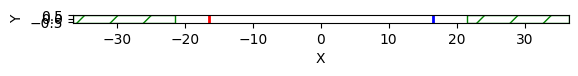

In [100]:
cell_size = mp.Vector3(sx,sy)

pml_layers = [mp.PML(thickness=dpml, direction=mp.X)]

k_point = mp.Vector3(fsrc * n_air).rotate(mp.Vector3(z=1), theta_i)

src_pt = mp.Vector3(-0.5*sx+dpml+0.5*dsub)
sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(fsrc),
        center=src_pt,
        size=mp.Vector3(y=sy),
        direction=mp.AUTOMATIC if theta_i == 0 else mp.NO_DIRECTION,
        eig_kpoint=k_point,
        eig_band=1,
        eig_parity=mp.EVEN_Y + mp.ODD_Z if theta_i == 0 else mp.ODD_Z,
        eig_match_freq=True,
    )
]

sim = mp.Simulation(resolution=resolution,
                    split_chunks_evenly=True,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    k_point=k_point,
                    sources=sources)


# n2f_pt = mp.Vector3(0.5*sx-dpml-0.5*dpad)
n2f_pt = mp.Vector3(0.5*sx-dpml-0.5*dsub)
n2f_obj = sim.add_near2far(fsrc, 0, 1, mp.Near2FarRegion(center=n2f_pt, size=mp.Vector3(y=sy)), nperiods=nperiods)

sim.plot2D()

In [28]:
# sim.run(until=10)

# ff_source = sim.get_farfields(n2f_obj, ff_res, center=mp.Vector3(ff_distance,0.5*ff_length), size=mp.Vector3(y=ff_length))

# sim.plot2D(fields=mp.Ez)

---

     block, center = (5,0,0)
          size (10,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.0625,3.0625,3.0625)
     block, center = (-1.5,0,0)
          size (3,0.6,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.0625,3.0625,3.0625)


<AxesSubplot: xlabel='X', ylabel='Y'>

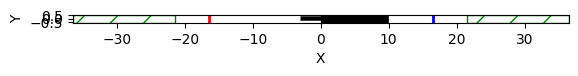

In [101]:
geometry = [
    mp.Block(material=grating_material, center=mp.Vector3(dsub/2), size=mp.Vector3(dsub, mp.inf)),
    mp.Block(material=grating_material, center=mp.Vector3(-gh/2), size=mp.Vector3(gh, gdc*gp)),
]

sim.reset_meep()

sim = mp.Simulation(resolution=resolution,
                    split_chunks_evenly=True,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    k_point=k_point,
                    sources=sources)

n2f_obj = sim.add_near2far(fsrc, 0, 1, mp.Near2FarRegion(center=n2f_pt, size=mp.Vector3(y=sy)), nperiods=nperiods)

sim.plot2D()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000185013 s
Working in 2D dimensions.
Computational cell is 10.4 x 2.4 x 0 with resolution 50
     block, center = (1,0,0)
          size (2,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.0625,3.0625,3.0625)
     block, center = (0,0,0)
          size (0.4,1.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.0625,3.0625,3.0625)
time for set_epsilon = 0.145754 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(2,0,0) = 2 after 29 iters
Meep progress: 39.89/100.0 = 39.9% done in 4.0s, 6.0s to go
on time step 3989 (time=39.89), 0.00100294 s/step
Meep progress: 91.93/100.0 = 91.9% done in 8.0s, 0.7s to go
on time step 9194 (time=91.94), 0.000768557 s/step
run 0 finished at t = 100.0 (10000 timesteps)
     block, center = (1,0,0)
          size (2,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     

<AxesSubplot:xlabel='X', ylabel='Y'>

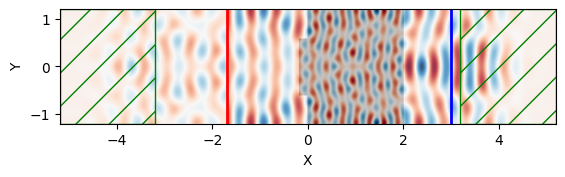

In [311]:
sim.run(until=100)

ff_unitcell = sim.get_farfields(n2f_obj, ff_res, center=mp.Vector3(ff_distance,0.5*ff_length), size=mp.Vector3(y=ff_length))

sim.plot2D(fields=mp.Ez)

In [312]:
sim.reset_meep()

freqs = mp.get_near2far_freqs(n2f_obj)
wvl = np.divide(1,freqs)
ff_lengths = np.linspace(0,ff_length,ff_npts)
angles = [math.degrees(math.atan(f)) for f in ff_lengths/ff_distance]

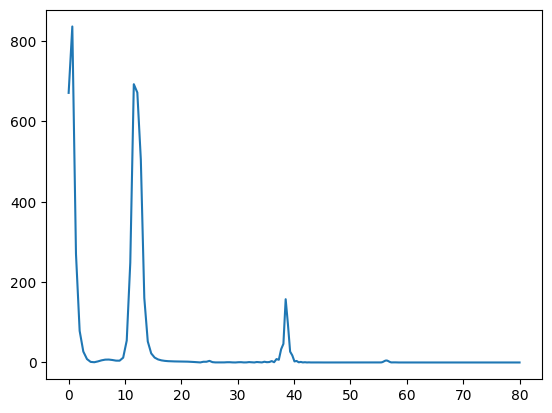

In [313]:
I = np.abs(ff_unitcell['Ez'])**2
plt.plot(angles, I)

In [314]:
print("Peaks should be at:")
print("theta0 = ", 0)
print("theta1 = ", math.degrees(math.asin(1/fsrc * 1/gp)))
print("theta2 = ", math.degrees(math.asin(2 * 1/fsrc * 1/gp)))
print("theta3 = ", math.degrees(math.asin(3 * 1/fsrc * 1/gp)))

Peaks should be at:
theta0 =  0
theta1 =  12.024699180565824
theta2 =  24.624318352164078
theta3 =  38.68218745348944


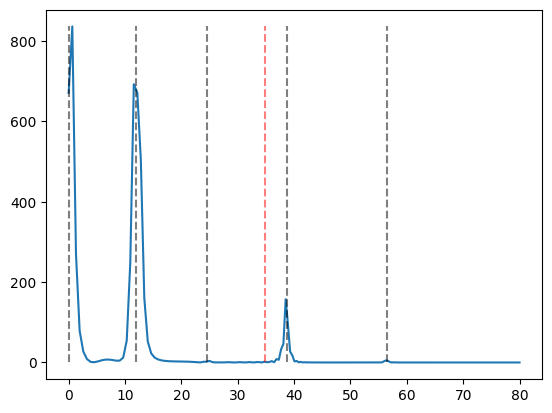

In [315]:
teorics = [math.degrees(math.asin(n/fsrc * 1/gp))+incident_angle for n in range(0,5)]

critical_angle = math.degrees(math.asin(n_air/n_grating))

plt.plot(angles, I)
plt.vlines(teorics, 0, np.max(I), color='k', linestyles='dashed', alpha=0.5)
plt.vlines(critical_angle, 0, np.max(I), color='r', linestyles='dashed', alpha=0.5)

In [316]:
# I = np.abs(ff_unitcell['Ez'])**2
# plt.plot(angles, I)

# from scipy.signal import argrelextrema
# max_ind = np.array(argrelextrema(I, np.greater))
# max_ind = max_ind[I[max_ind] > 0.1*np.max(I)]
# idx = np.argmax(I)
# max_ind = max_ind[idx < max_ind]
# r = I[max_ind]
# plt.plot(np.array(angles)[max_ind], r, 'ro') # Peaks with order > 1
# plt.plot(np.array(angles)[idx], np.max(I), 'bo') # 0th order peak
# plt.title('Peaks with incident angle %i' % incident_angle)
# # plt.savefig('diff_pattern_%i.png' % incident_angle)

---
### Comparison with the theory

$n_\text{mat} = \frac1{\sin\varphi_{l,\text{out}}}\left(\sin\varphi_{l,\text{in}}+l\frac\lambda\Lambda\right)$

We find


In [317]:
i = 0
for angle in np.array(angles)[max_ind]:
    print('l=%i angle: %f' % (i, angle))
    i += 1

NameError: name 'max_ind' is not defined

In [ ]:
theta_out = np.radians(np.array(angles)[max_ind][0])
n_pred = (np.sin(theta_i) + 1/(fsrc*gp)) / np.sin(theta_out)
n_pred

0.30759790956267063

---
Critical angle: $\theta=90$, $\sin\theta=1$

In [ ]:
ca = np.arcsin(1/n_grating)
ca*180/np.pi

41.810314895778596

Text(0, 0.5, 'Critical angle (deg)')

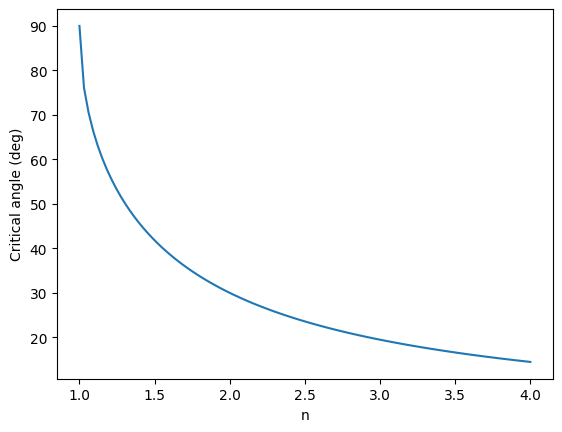

In [ ]:
x = np.linspace(1, 4, 100)
y = np.arcsin(1/x)*180/np.pi
plt.plot(x,y)
plt.xlabel('n')
plt.ylabel('Critical angle (deg)')

---

In [ ]:
max_intensities_0 = []
max_intensities_1 = []

for n in np.arange(1.5, 4, 0.3):
    grating_material = mp.Medium(index=n)
    geometry = [mp.Block(material=grating_material, center=mp.Vector3(), size=mp.Vector3(gh, gdc*gp))]
    sim.reset_meep()
    sim = mp.Simulation(resolution=resolution,
                    split_chunks_evenly=True,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    k_point=k_point,
                    sources=sources)
    n2f_obj = sim.add_near2far(fsrc, 0, 1, mp.Near2FarRegion(center=n2f_pt, size=mp.Vector3(y=sy)), nperiods=nperiods)
    sim.run(until=100)
    ff_unitcell = sim.get_farfields(n2f_obj, ff_res, center=mp.Vector3(ff_distance,0.5*ff_length), size=mp.Vector3(y=ff_length))
    I = np.abs(ff_unitcell['Ez'])**2
    max_intensities_0.append(np.max(I[:10]))
    max_intensities_1.append(np.max(I[10:]))

-----------
Initializing structure...
time for choose_chunkdivision = 0.012409 s
Working in 2D dimensions.
Computational cell is 10.2 x 2.4 x 0 with resolution 50
     block, center = (0,0,0)
          size (0.2,1.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
time for set_epsilon = 0.203317 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(2,0,0) = 2 after 29 iters
Meep progress: 54.870000000000005/100.0 = 54.9% done in 4.0s, 3.3s to go
on time step 5487 (time=54.87), 0.000729019 s/step


run 0 finished at t = 100.0 (10000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 8.60691e-05 s
Working in 2D dimensions.
Computational cell is 10.2 x 2.4 x 0 with resolution 50
     block, center = (0,0,0)
          size (0.2,1.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
time for set_epsilon = 0.072902 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(2,0,0) = 2 after 29 iters
Meep progress: 55.300000000000004/100.0 = 55.3% done in 4.0s, 3.2s to go
on time step 5530 (time=55.3), 0.000723438 s/step


run 0 finished at t = 100.0 (10000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 8.51154e-05 s
Working in 2D dimensions.
Computational cell is 10.2 x 2.4 x 0 with resolution 50
     block, center = (0,0,0)
          size (0.2,1.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.41,4.41,4.41)
time for set_epsilon = 0.0749121 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(2,0,0) = 2 after 29 iters
Meep progress: 56.02/100.0 = 56.0% done in 4.0s, 3.1s to go
on time step 5602 (time=56.02), 0.000714092 s/step


run 0 finished at t = 100.0 (10000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 9.17912e-05 s
Working in 2D dimensions.
Computational cell is 10.2 x 2.4 x 0 with resolution 50
     block, center = (0,0,0)
          size (0.2,1.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
time for set_epsilon = 0.0834131 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(2,0,0) = 2 after 29 iters
Meep progress: 54.980000000000004/100.0 = 55.0% done in 4.0s, 3.3s to go
on time step 5498 (time=54.98), 0.000727625 s/step


run 0 finished at t = 100.0 (10000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 8.60691e-05 s
Working in 2D dimensions.
Computational cell is 10.2 x 2.4 x 0 with resolution 50
     block, center = (0,0,0)
          size (0.2,1.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (7.29,7.29,7.29)
time for set_epsilon = 0.084378 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(2,0,0) = 2 after 29 iters
Meep progress: 54.83/100.0 = 54.8% done in 4.0s, 3.3s to go
on time step 5483 (time=54.83), 0.000729551 s/step
Meep progress: 99.44/100.0 = 99.4% done in 8.0s, 0.0s to go
on time step 9945 (time=99.45), 0.000896607 s/step
run 0 finished at t = 100.0 (10000 timesteps)
get_farfields_array working on point 325 of 500 (65% done), 0.0123289 s/point


-----------
Initializing structure...
time for choose_chunkdivision = 7.70092e-05 s
Working in 2D dimensions.
Computational cell is 10.2 x 2.4 x 0 with resolution 50
     block, center = (0,0,0)
          size (0.2,1.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (9,9,9)
time for set_epsilon = 0.0797269 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(2,0,0) = 2 after 29 iters
Meep progress: 54.64/100.0 = 54.6% done in 4.0s, 3.3s to go
on time step 5464 (time=54.64), 0.000732086 s/step


run 0 finished at t = 100.0 (10000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000103951 s
Working in 2D dimensions.
Computational cell is 10.2 x 2.4 x 0 with resolution 50
     block, center = (0,0,0)
          size (0.2,1.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (10.89,10.89,10.89)
time for set_epsilon = 0.083468 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(2,0,0) = 2 after 29 iters
Meep progress: 55.75/100.0 = 55.8% done in 4.0s, 3.2s to go
on time step 5575 (time=55.75), 0.000717542 s/step


run 0 finished at t = 100.0 (10000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 8.60691e-05 s
Working in 2D dimensions.
Computational cell is 10.2 x 2.4 x 0 with resolution 50
     block, center = (0,0,0)
          size (0.2,1.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.96,12.96,12.96)
time for set_epsilon = 0.0720232 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(2,0,0) = 2 after 29 iters
Meep progress: 56.51/100.0 = 56.5% done in 4.0s, 3.1s to go
on time step 5651 (time=56.51), 0.000708002 s/step


run 0 finished at t = 100.0 (10000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000108004 s
Working in 2D dimensions.
Computational cell is 10.2 x 2.4 x 0 with resolution 50
     block, center = (0,0,0)
          size (0.2,1.2,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (15.21,15.21,15.21)
time for set_epsilon = 0.0789309 s
-----------
Meep: using complex fields.
MPB solved for frequency_1(2,0,0) = 2 after 29 iters
Meep progress: 55.370000000000005/100.0 = 55.4% done in 4.0s, 3.2s to go
on time step 5537 (time=55.37), 0.000722511 s/step
run 0 finished at t = 100.0 (10000 timesteps)


Text(0, 0.5, 'Intensity of 1st order peak')

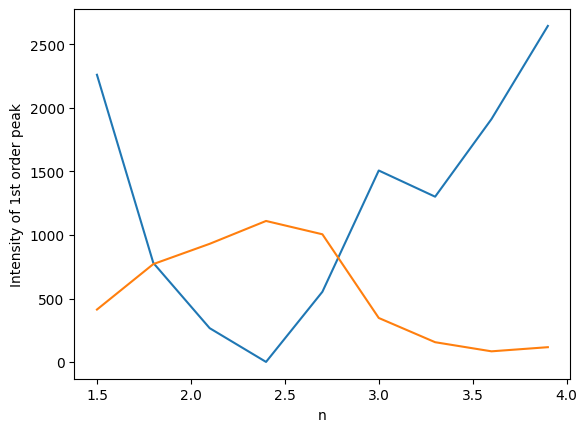

In [ ]:
plt.plot(np.arange(1.5, 4, 0.3), max_intensities_0)
plt.plot(np.arange(1.5, 4, 0.3), max_intensities_1)
plt.xlabel('n')
plt.ylabel('Intensity of 1st order peak')

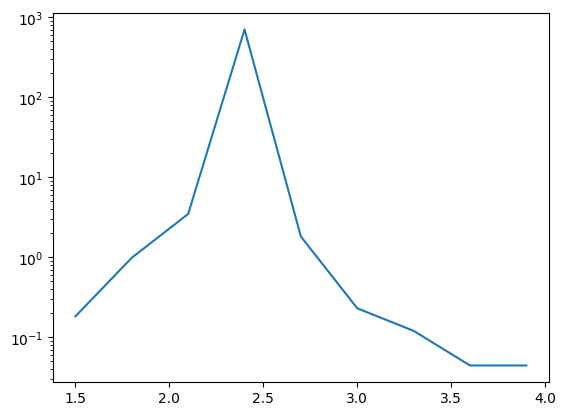

In [ ]:
plt.semilogy(np.arange(1.5, 4, 0.3), np.array(max_intensities_1)/np.array(max_intensities_0))

---

In [ ]:
n = np.arange(1.5, 4, 0.2)
n_i = 1
th_i = 0
th_t1 = 12.0247
th_t0 = 0
# r = (n_i*np.cos(th_i) - n*np.cos(th_t)) / (n_i*np.cos(th_i) + n*np.cos(th_t))
t1 = 2*n_i*np.cos(th_i) / (n_i*np.cos(th_i) + n*np.cos(th_t1))
t0 = 2*n_i*np.cos(th_i) / (n_i*np.cos(th_i) + n*np.cos(th_t0))

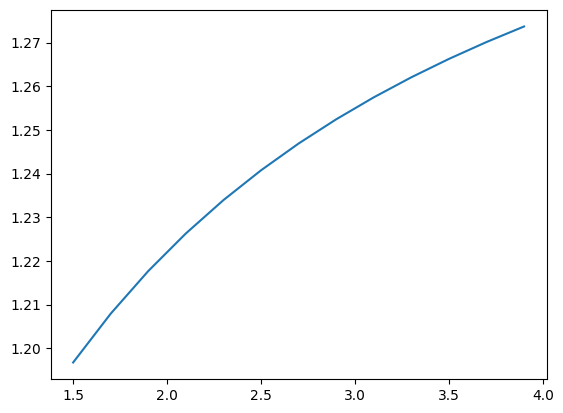

In [ ]:
plt.plot(n, t1**2/t0**2)